### Building House Price Predicition Model

**Downloading the Dataset**

In [ ]:
# Download dataset directly
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip
!unzip house-prices-advanced-regression-techniques.zip


  0%|          | 0.00/199k [00:00<?, ?B/s]
100%|██████████| 199k/199k [00:00<00:00, 53.6MB/s]


Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


**Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Using Train.csv as Full Dataset**

In [ ]:
df = pd.read_csv("data/train.csv")
pd.set_option("display.max_columns",None) #alternative use - pd.option_context 
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
df.shape

(1460, 81)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Checking the NA values in each features**

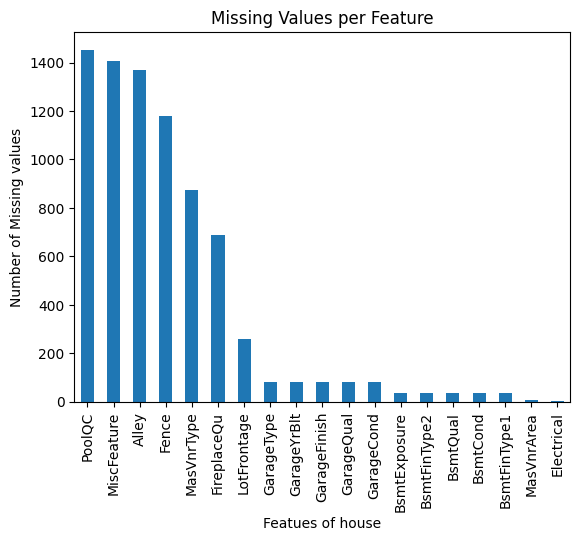

In [ ]:
nulls = df.isnull().sum()
plot_nulls = nulls[nulls > 0].sort_values(ascending=False)
plot = plot_nulls.plot(kind='bar')
plt.xlabel("Featues of house")
plt.ylabel("Number of Missing values")
plt.title("Missing Values per Feature")
plt.show()

**Identifying the Unique values**

In [57]:
unique_cols = {}
for cols in df.columns:
    unique_cols["cols"] = df[cols].unique()
    print(f"Column name {cols} with unique values {df[cols].unique()}")
    print("-"*50)   
        

Column name Id with unique values [   1    2    3 ... 1458 1459 1460]
--------------------------------------------------
Column name MSSubClass with unique values [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
--------------------------------------------------
Column name MSZoning with unique values ['RL' 'RM' 'C (all)' 'FV' 'RH']
--------------------------------------------------
Column name LotFrontage with unique values [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153. 

**Identifying Numerical and Categorical Featured**

In [ ]:
numerical_columns=df.select_dtypes(include=["int64","float64"]).drop("Id", axis = 1).columns.to_list() #removed Id

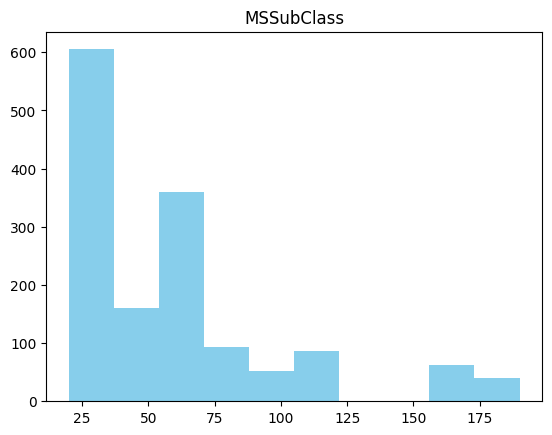

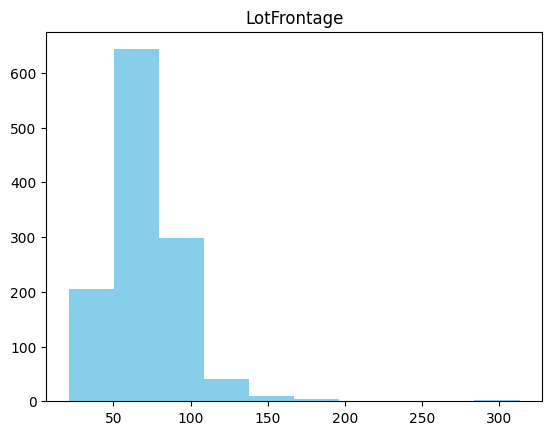

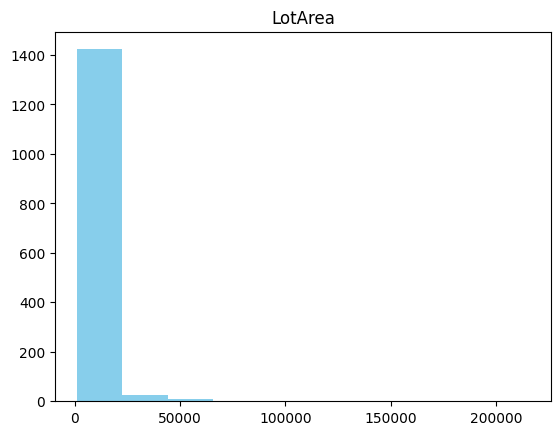

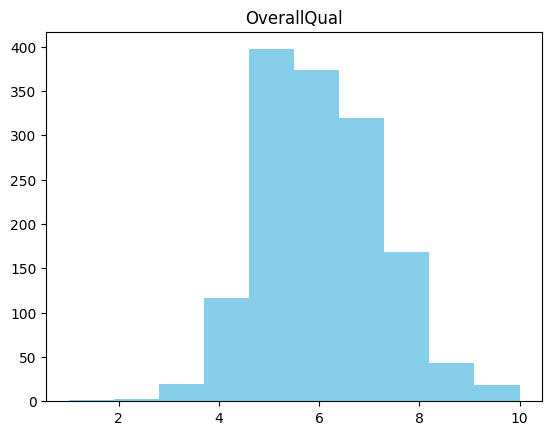

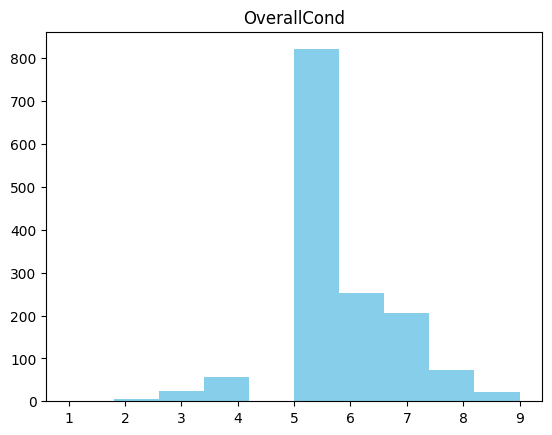

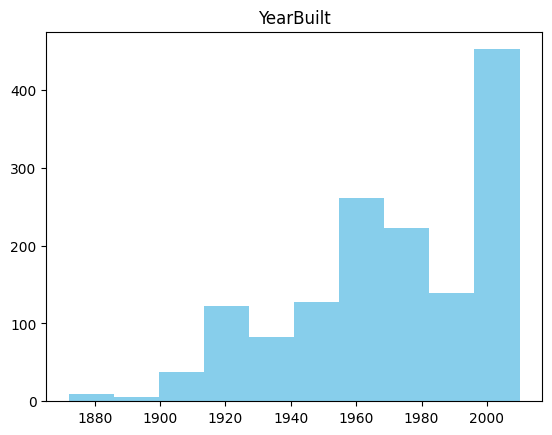

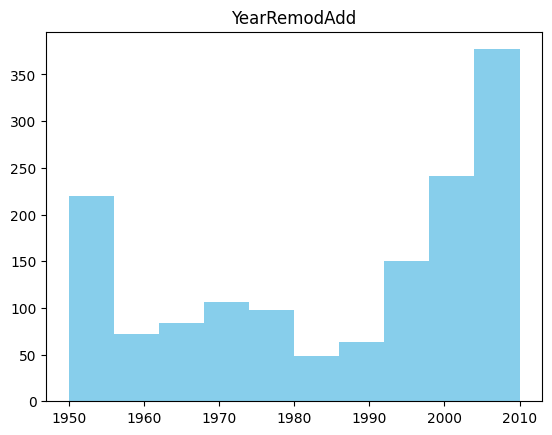

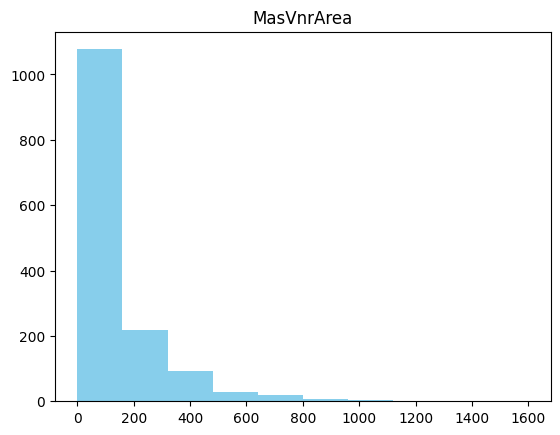

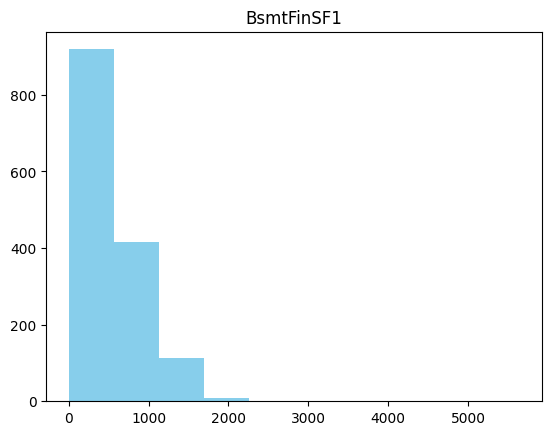

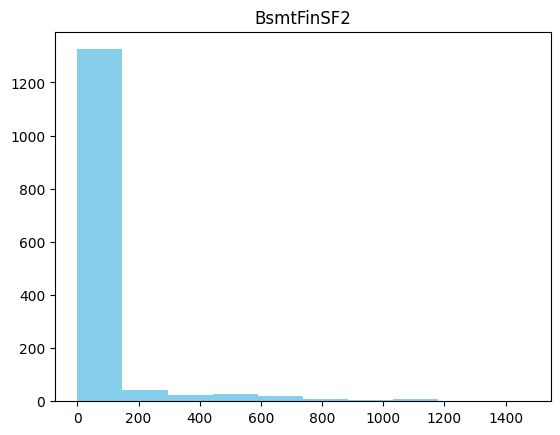

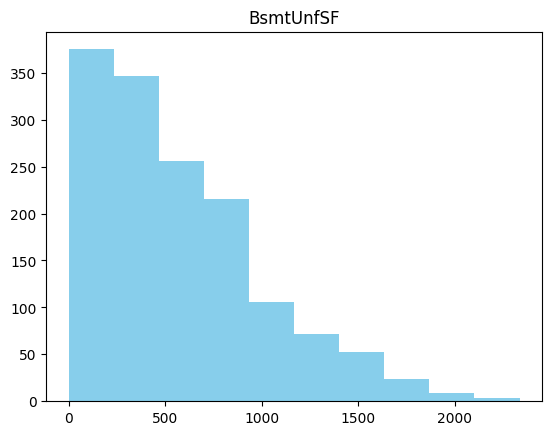

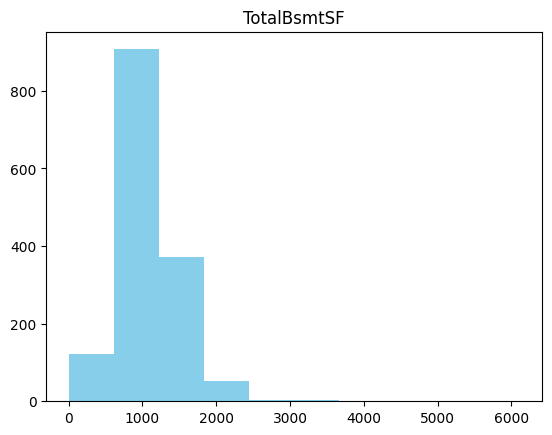

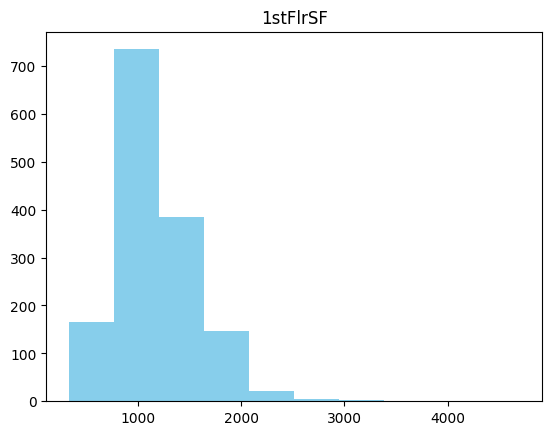

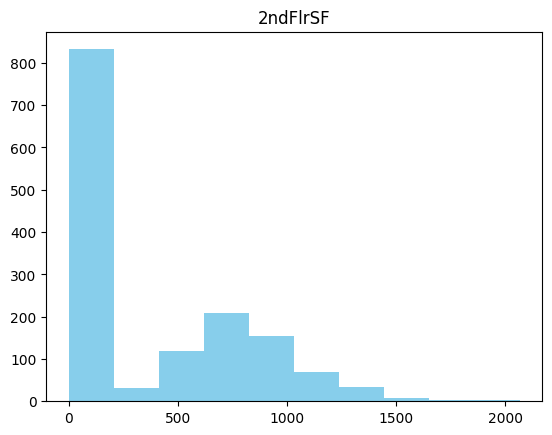

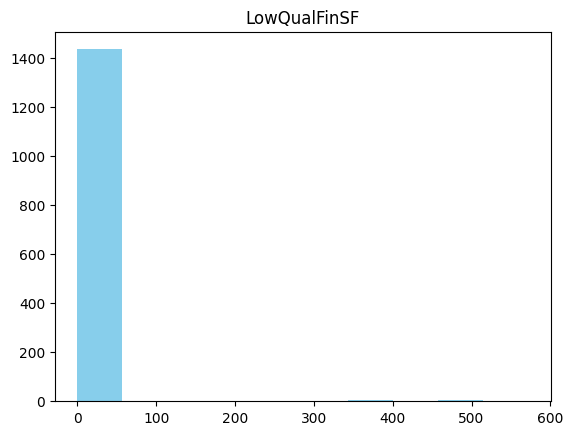

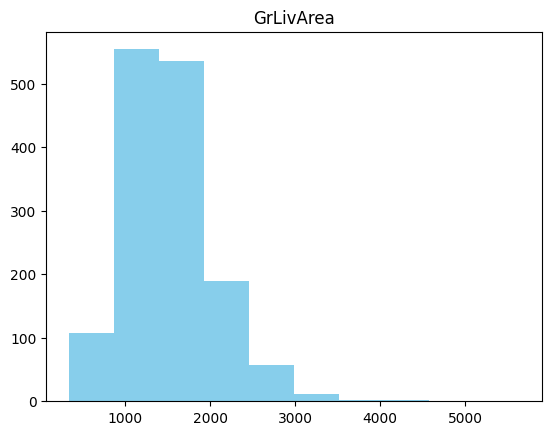

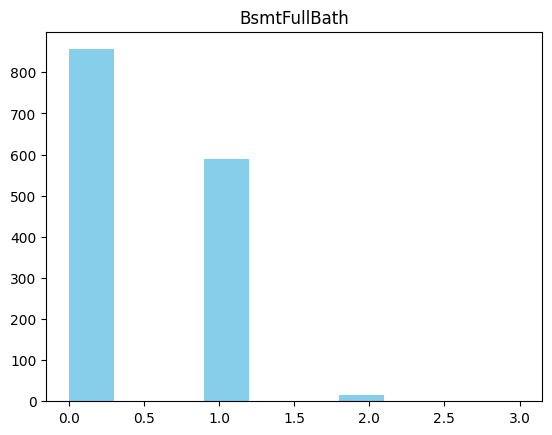

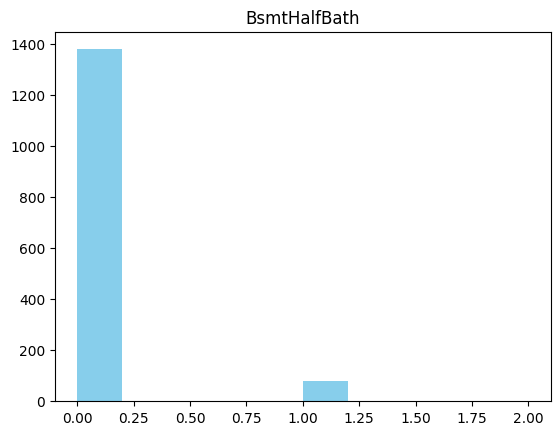

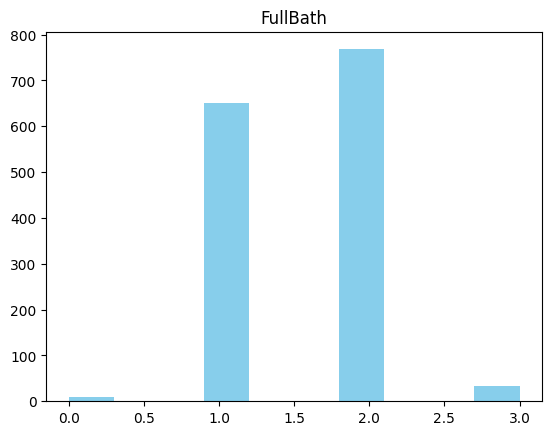

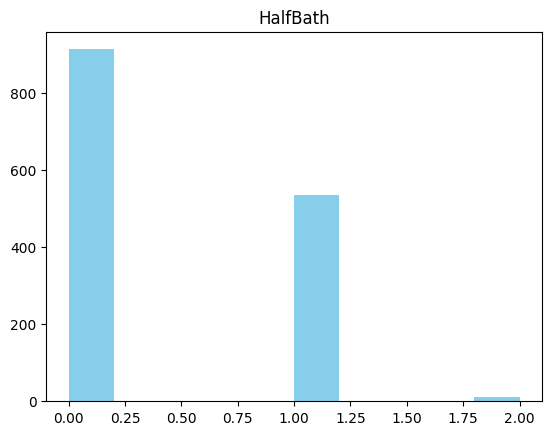

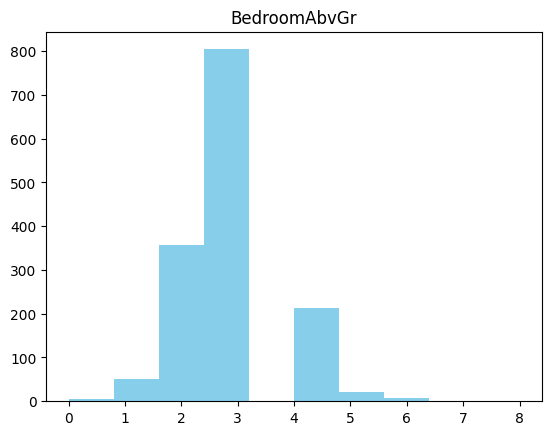

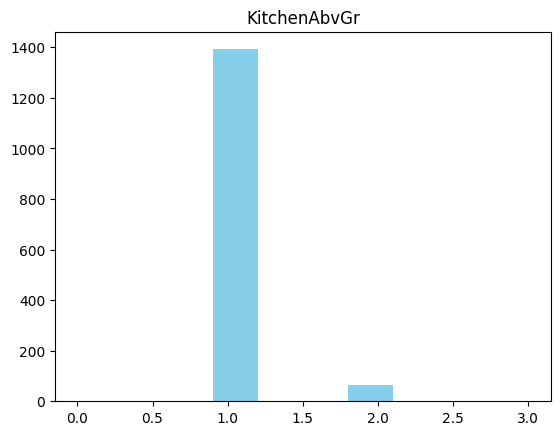

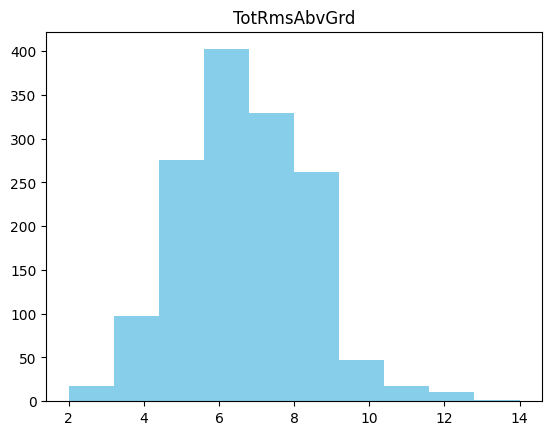

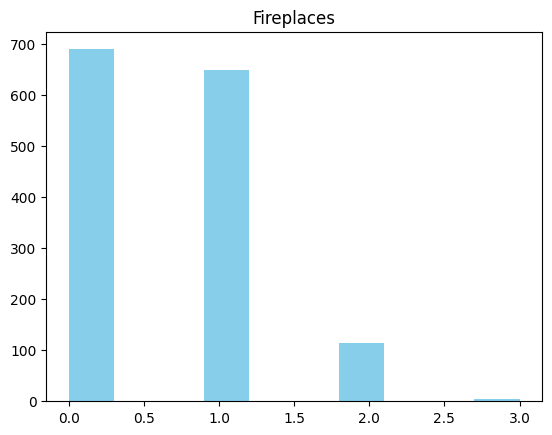

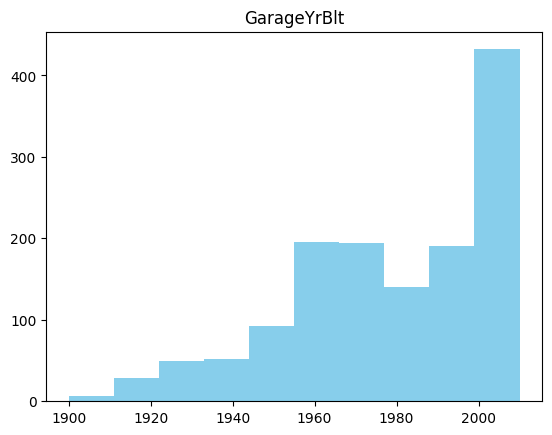

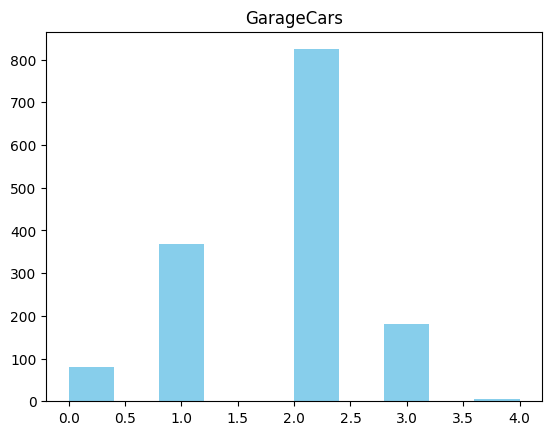

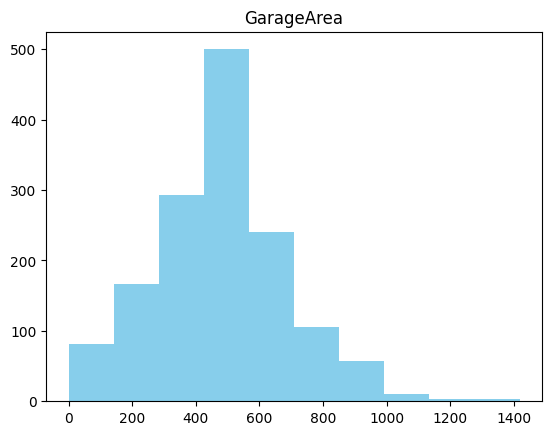

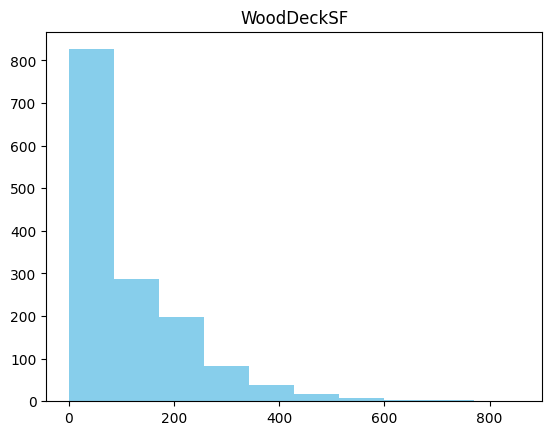

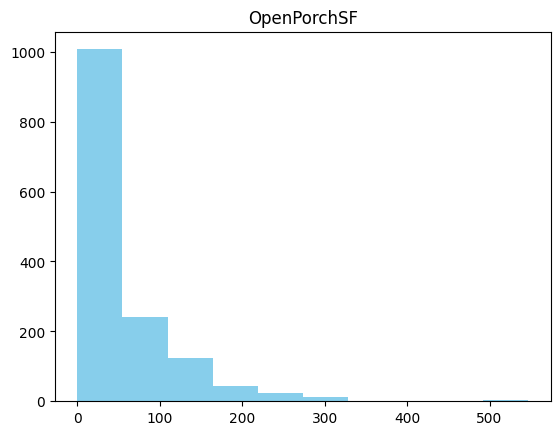

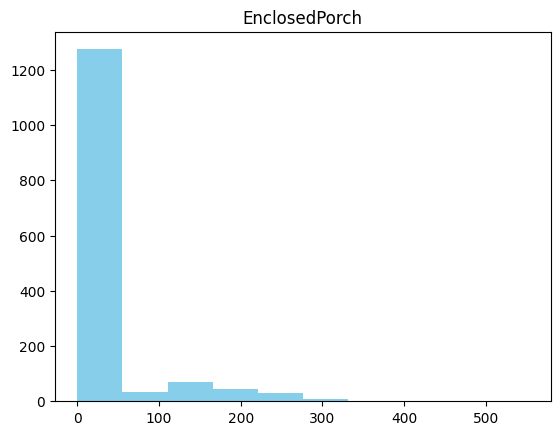

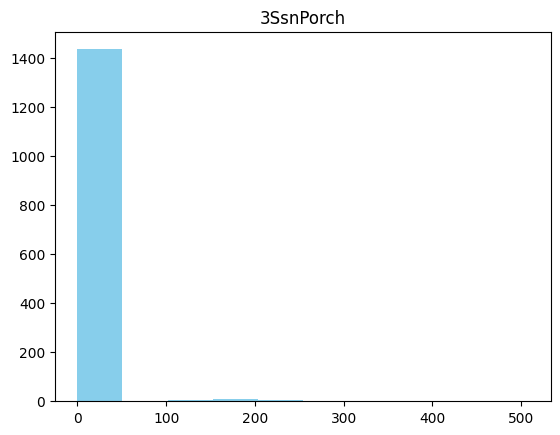

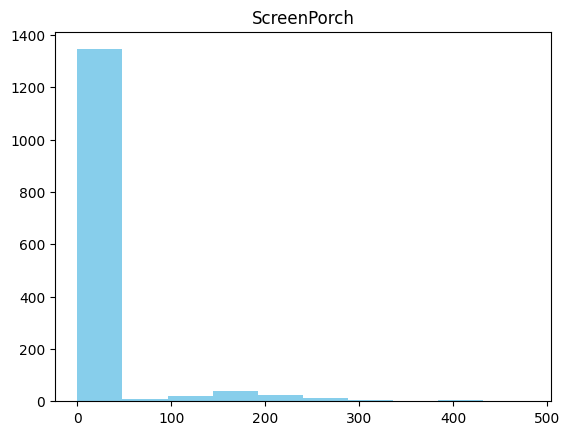

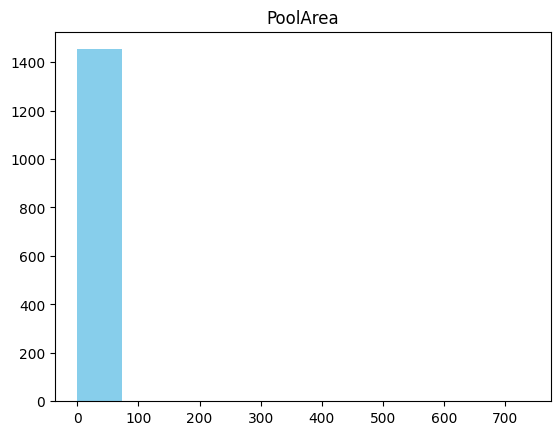

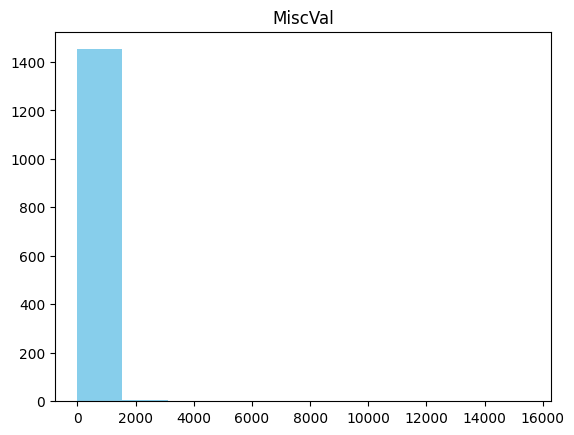

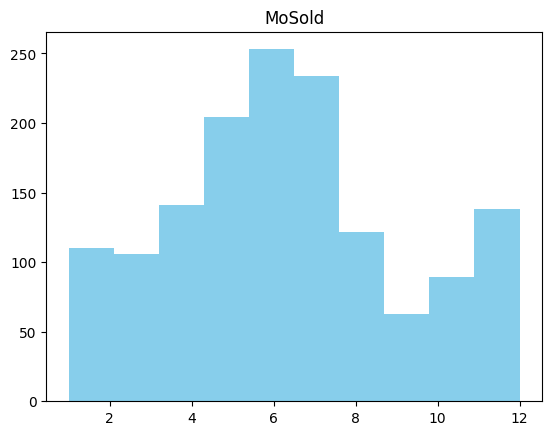

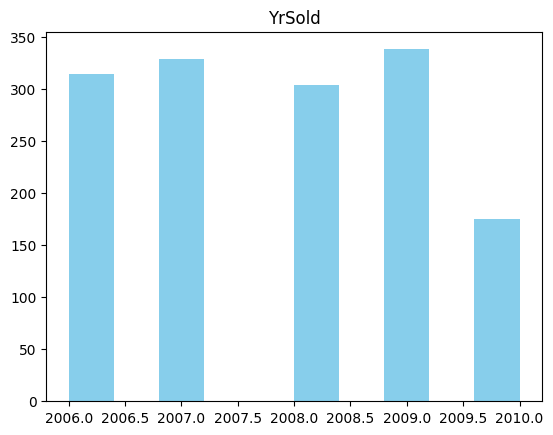

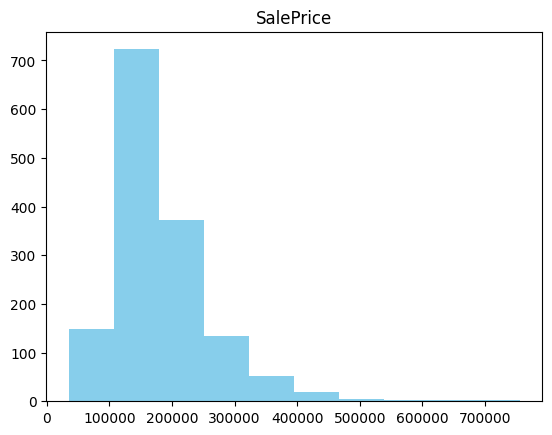

In [77]:
for cols in numerical_columns:
    plt.hist(x = cols,data = df, color = "skyblue")
    plt.title(cols)
    plt.plot()
    plt.show()

**Checking the distribution target varaiable**

In [ ]:
df["SalePrice"].value_counts()

SalePrice
140000    20
135000    17
145000    14
155000    14
190000    13
110000    13
160000    12
115000    12
130000    11
139000    11
125000    10
180000    10
143000    10
144000    10
185000    10
100000     9
127000     9
175000     9
147000     9
215000     8
176000     8
170000     8
250000     8
129000     8
165000     8
200000     8
141000     8
230000     8
174000     7
181000     7
178000     7
235000     7
173000     7
119000     7
112000     7
148000     7
128000     7
120000     7
137500     6
132500     6
189000     6
133000     6
187500     6
124000     6
108000     6
157000     6
240000     6
132000     6
239000     6
127500     6
152000     6
260000     6
225000     6
158000     6
118000     6
205000     6
113000     6
179900     5
172500     5
136500     5
177000     5
105000     5
207500     5
154000     5
137000     5
275000     5
210000     5
192000     5
290000     5
151000     5
214000     5
171000     5
220000     5
150000     4
128500     4
109500     4
16

**Insights**
* Most of the features are skewed.
* There are few columns with missing values. We need to impute them accordingly.
* Scaling  is needed as the values are on different scale which will create the problem for non-tree based models.


**EDA**

**Box Plot for Identifying the Outliers**

C:\Users\faraz_81kv05g\AppData\Local\Temp\ipykernel_22836\1450707529.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,5))


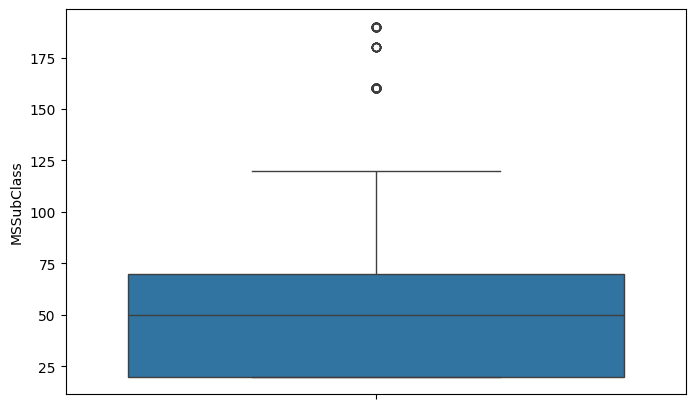

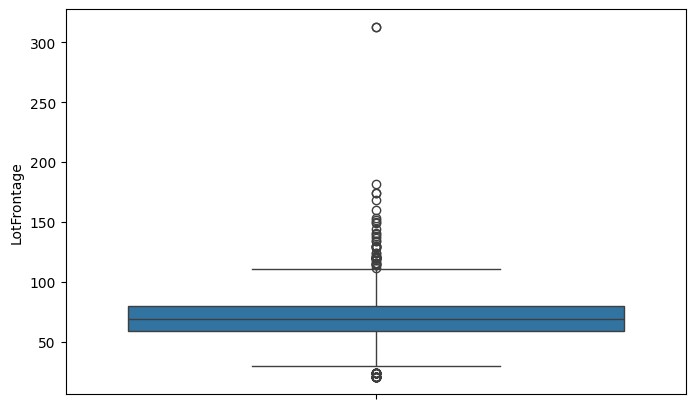

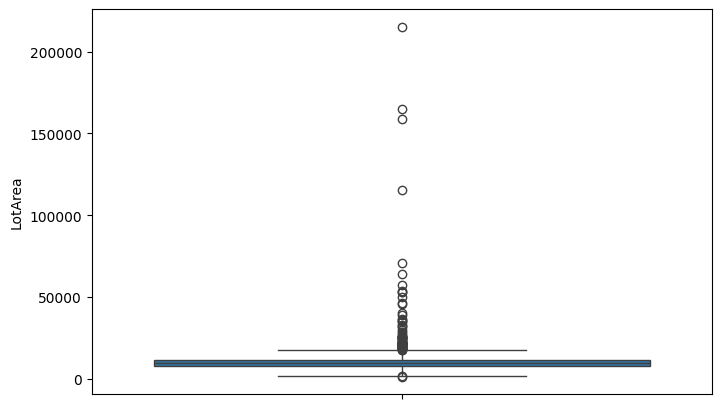

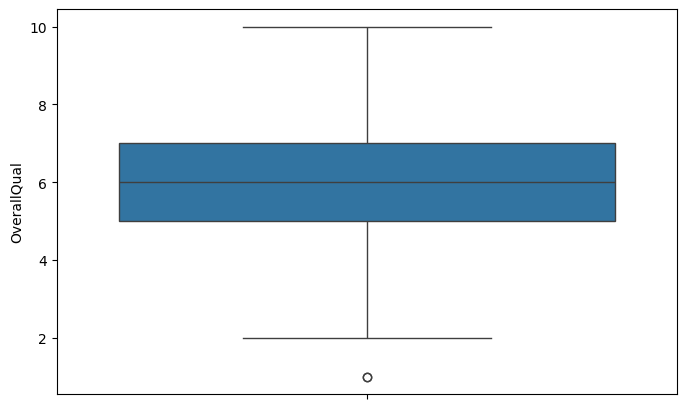

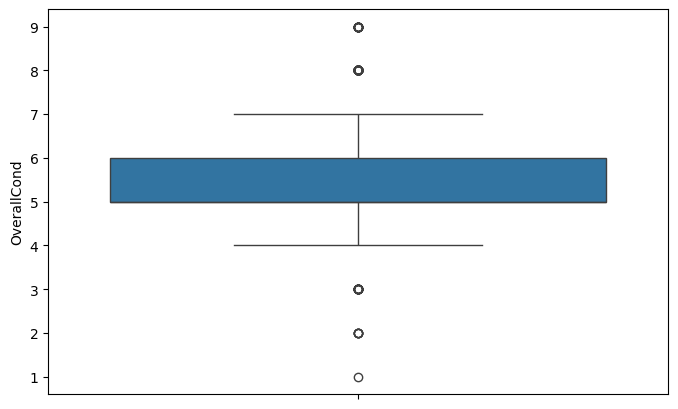

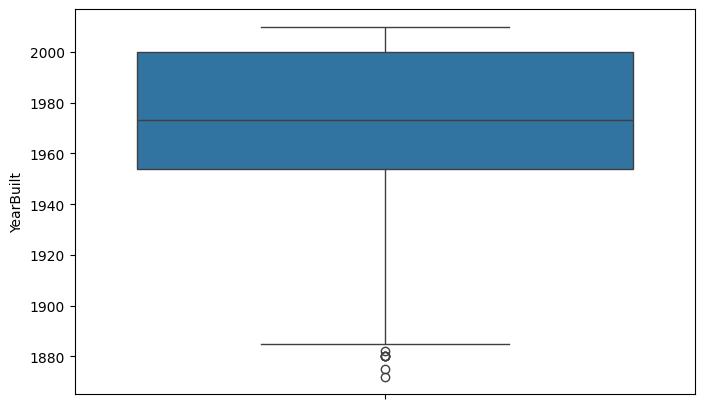

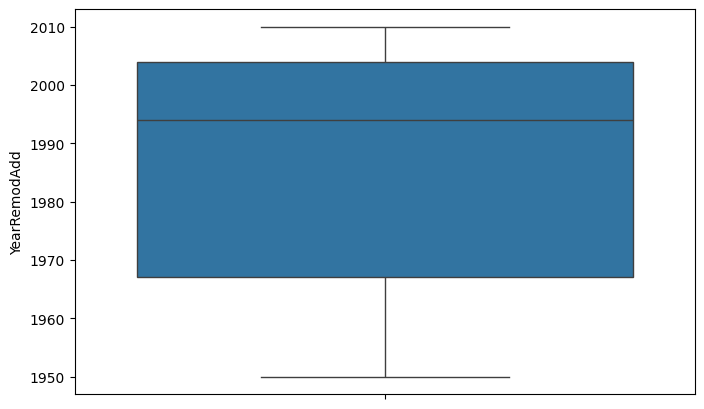

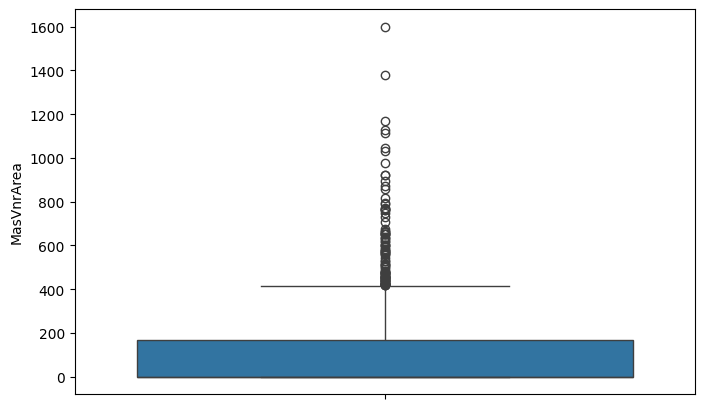

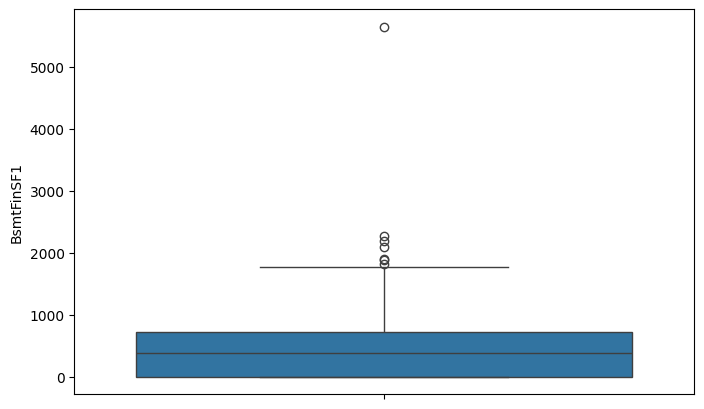

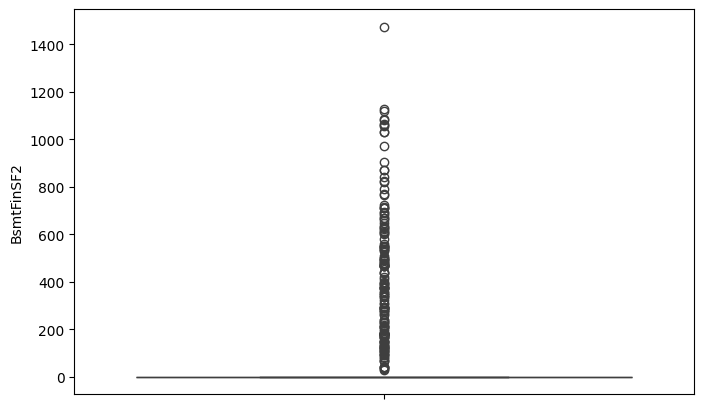

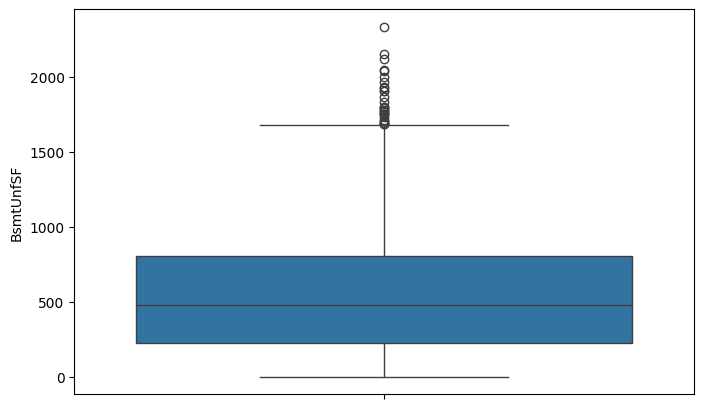

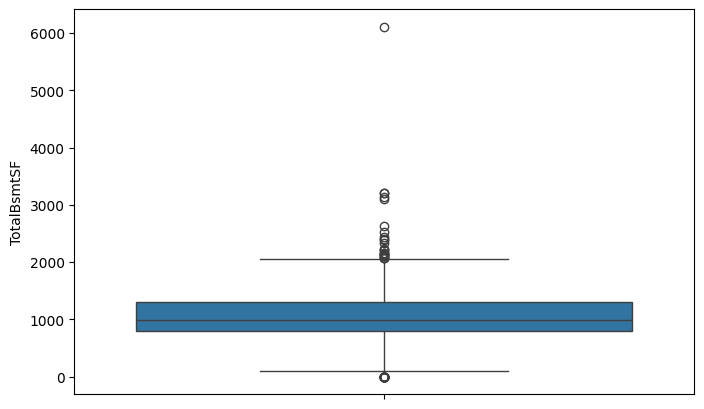

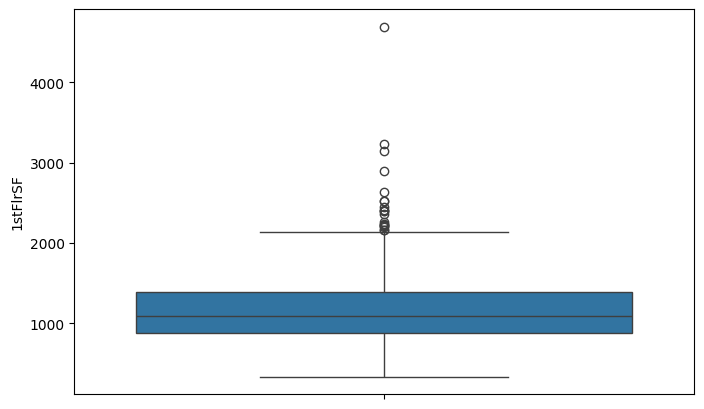

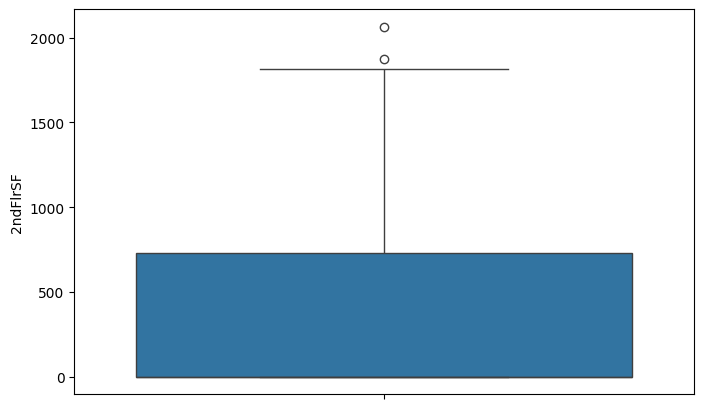

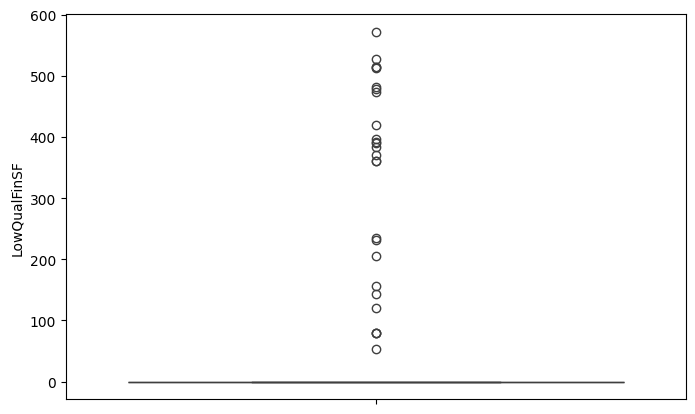

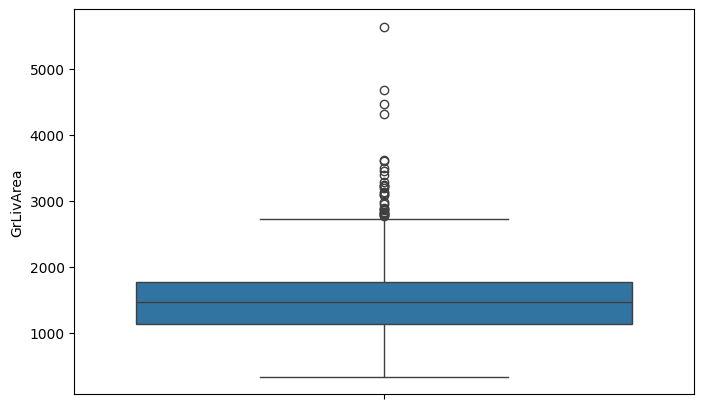

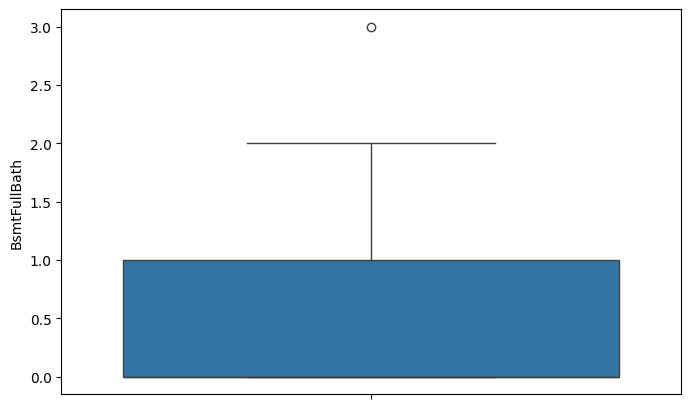

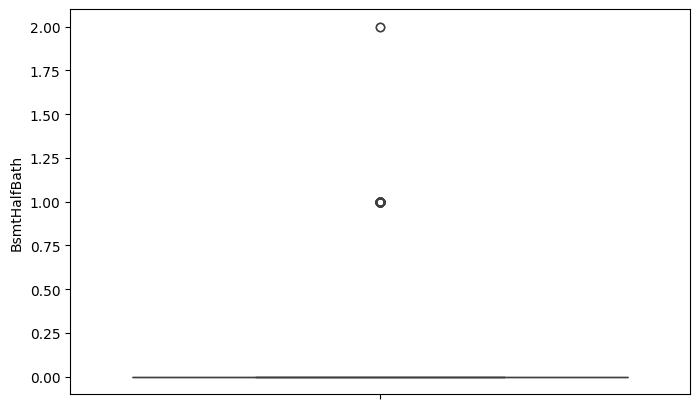

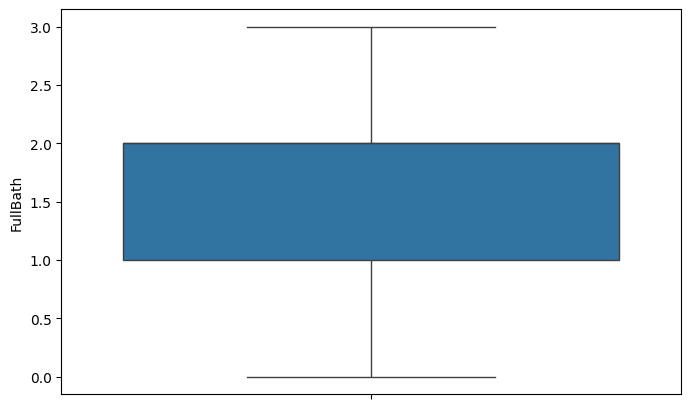

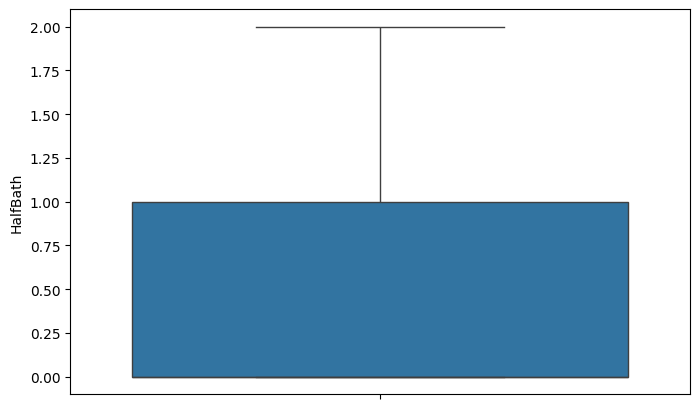

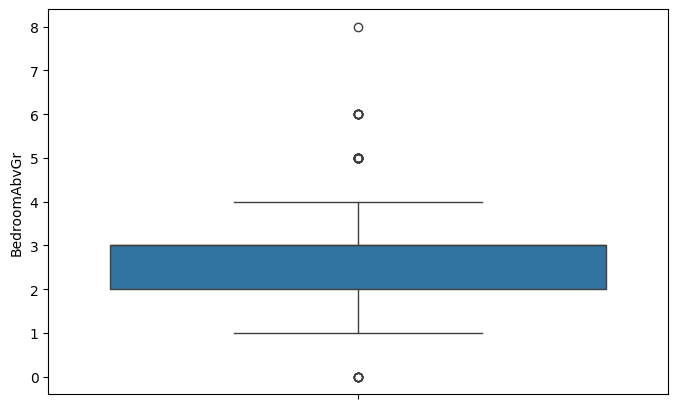

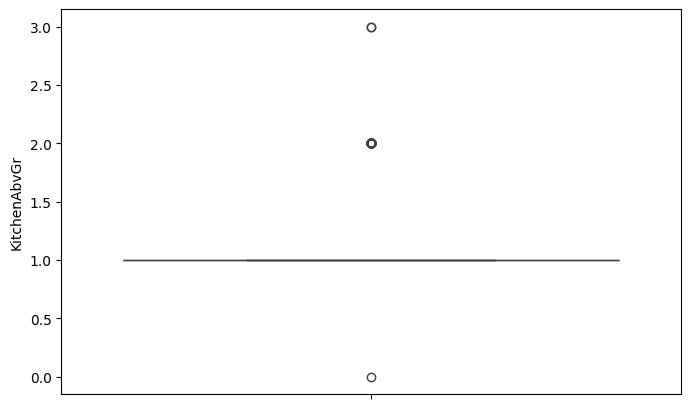

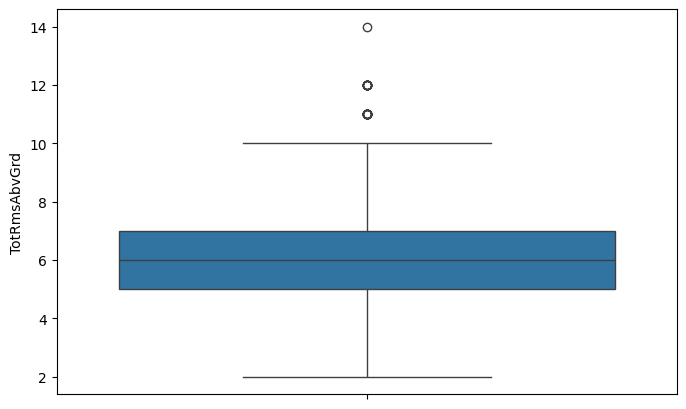

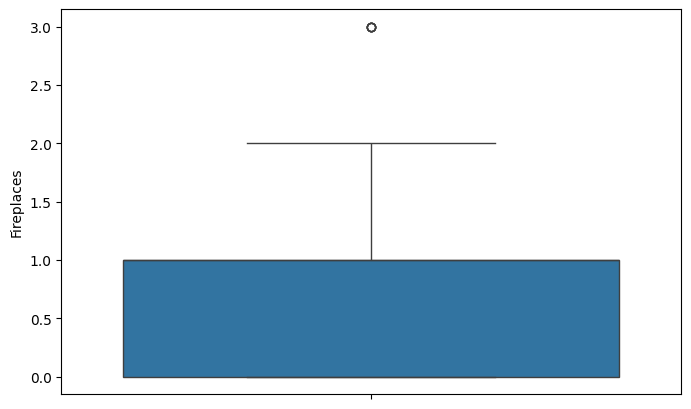

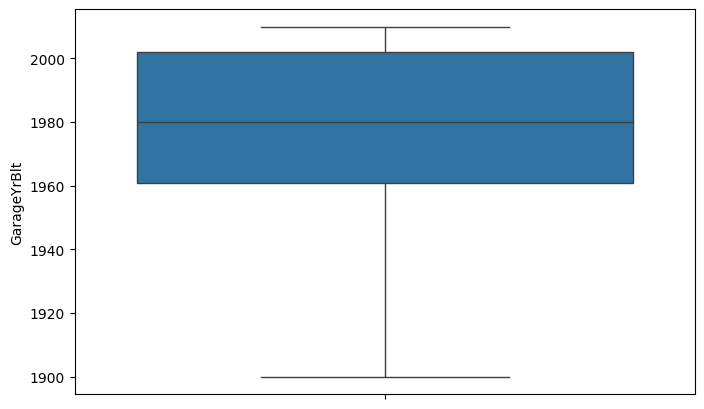

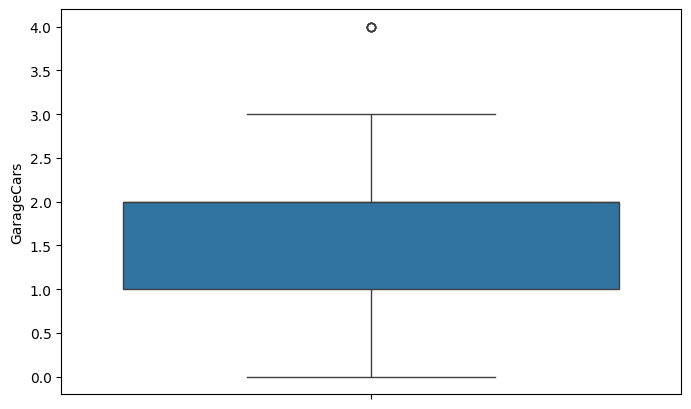

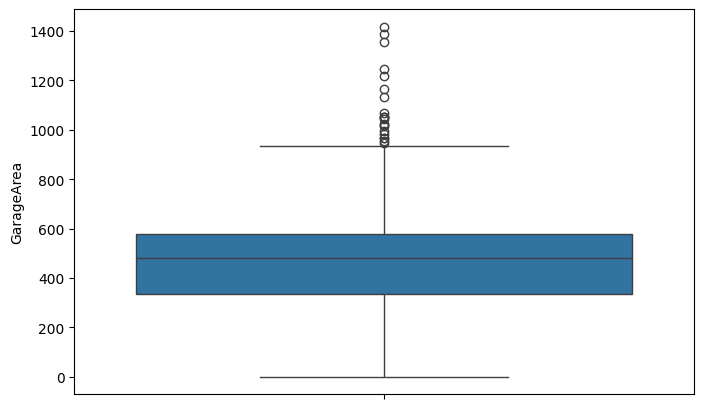

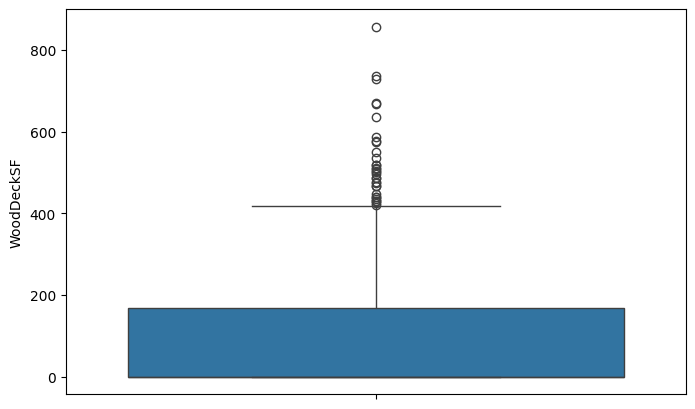

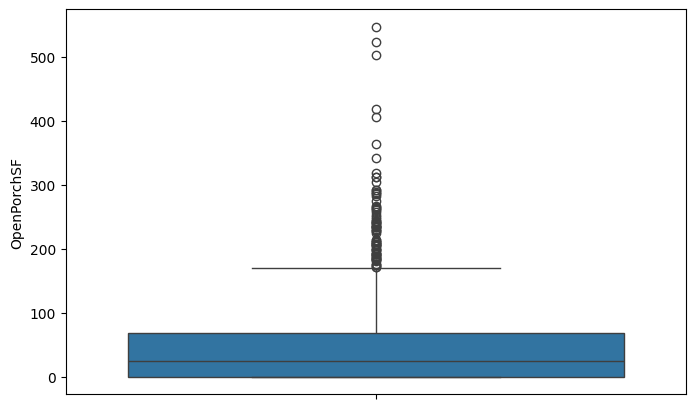

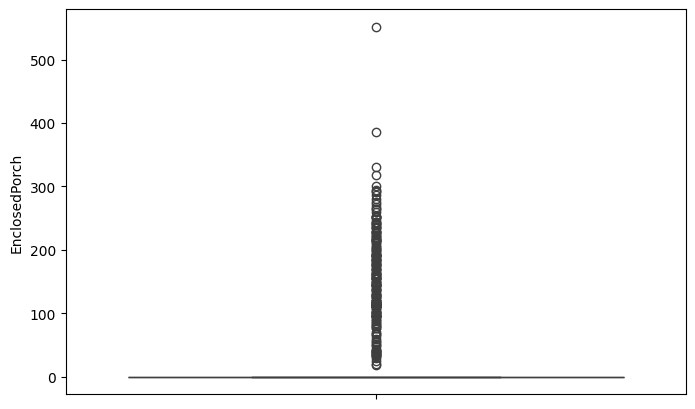

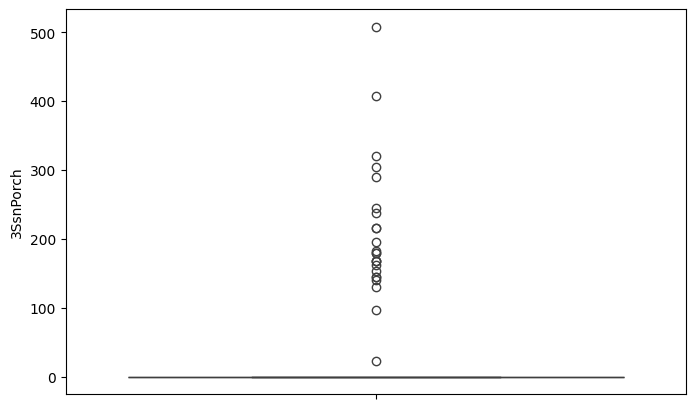

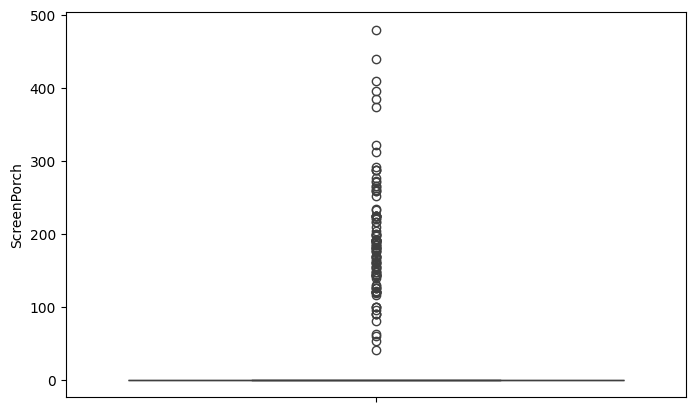

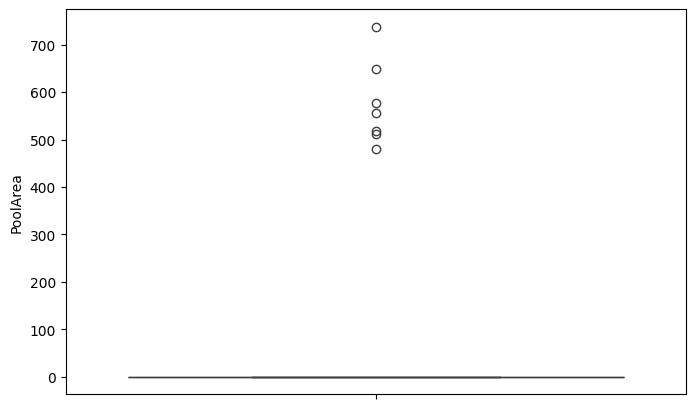

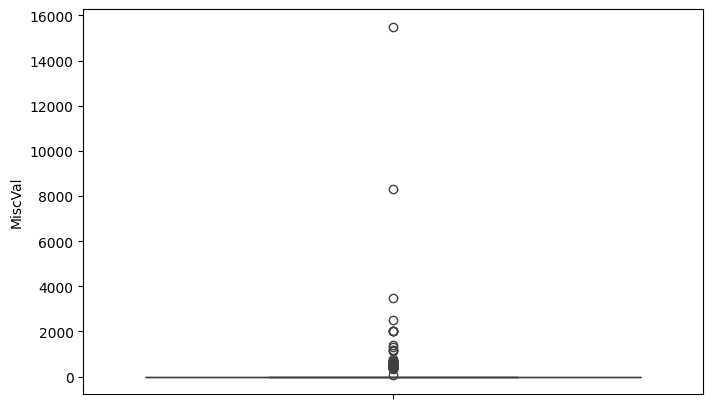

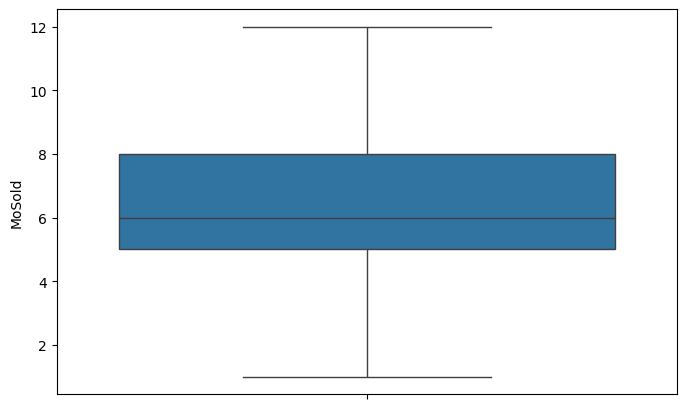

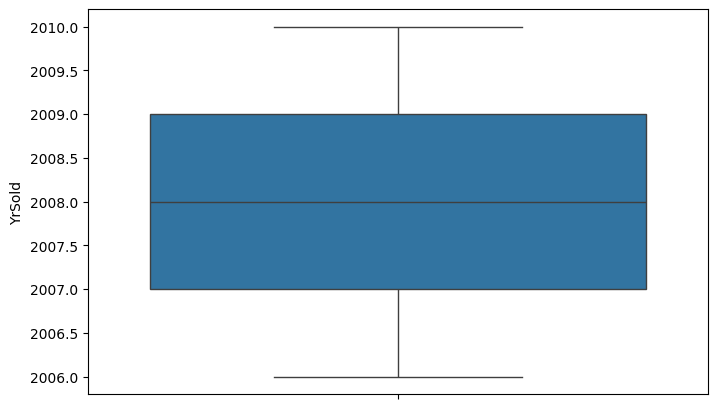

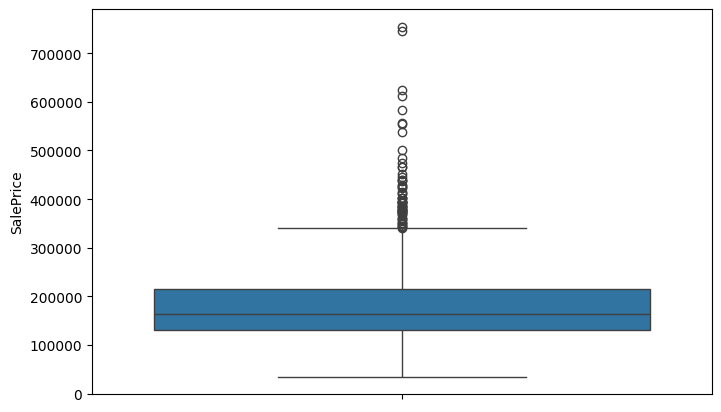

In [92]:
for cols in numerical_columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(df[cols])

**Heatmap for Numerical columns**

<Axes: >

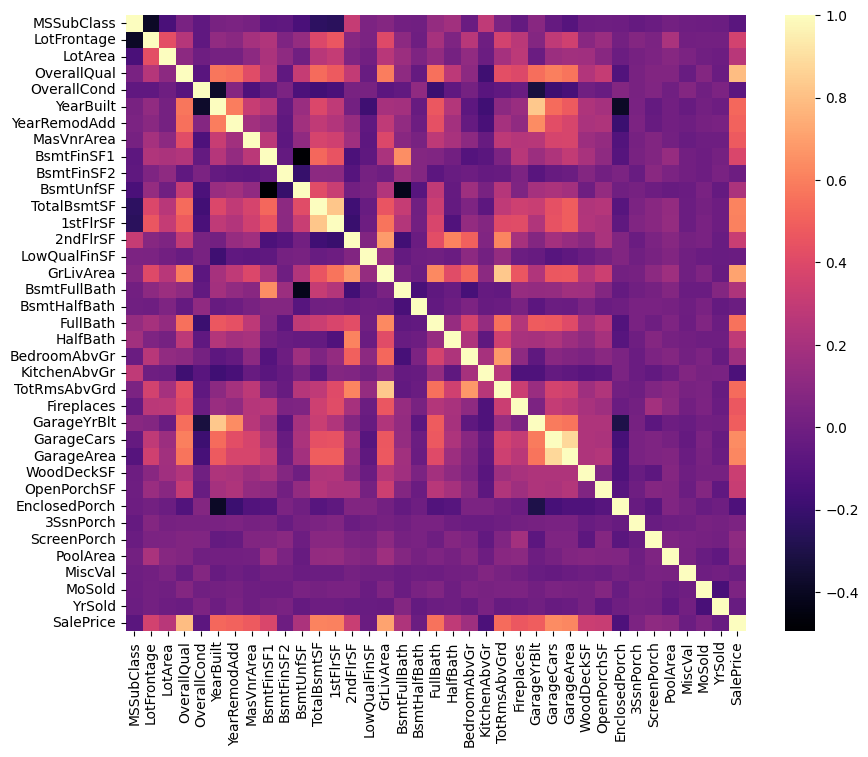

In [111]:
plt.figure(figsize = (10,8))
sns.heatmap(df[[cols for cols in numerical_columns]].corr(numeric_only = True), cmap = "magma",cbar = True )

**Data Preprocessing**

**Training and Testing Data Split**

**Model Evaluation**

In [110]:
list = [cols for cols in numerical_columns]

AttributeError: module 'pandas' has no attribute 'colors'